In [1]:
import os
import random

import torch
import decord
import matplotlib.pyplot as plt
from PIL import Image
from torchvision.transforms.functional import to_tensor
from tqdm.auto import tqdm

decord.bridge.set_bridge("torch")

In [2]:
from models.fsg import FSGWholeEvalPLWrapper as FSG

In [3]:
model = FSG

In [4]:
list_dir = lambda x: [os.path.join(x, i) for i in os.listdir(x)]

In [5]:
def load_image(path):
    return to_tensor(Image.open(path))[:3] * 255

In [6]:
def random_sample(list, k, seed):
    random.seed(seed)
    return random.sample(list, k)

In [7]:
def load_first_frame_of_video(path):
    vr = decord.VideoReader(path)
    return vr[0].permute(2, 0, 1)

def load_second_frame_of_video(path):
    vr = decord.VideoReader(path)
    return vr[1].permute(2, 0, 1)

In [8]:
def get_off_diag_elements(matrix):
    """
    Extracts off-diagonal elements of a 2D matrix using PyTorch.

    Args:
        matrix (torch.Tensor): The input 2D matrix.

    Returns:
        torch.Tensor: A 1D tensor containing the off-diagonal elements of the input matrix.
    """
    m, n = matrix.size()
    mask = torch.ones(m, n, dtype=torch.bool)
    mask = mask.triu(diagonal=1) | mask.tril(diagonal=-1)
    return matrix[mask].flatten()


In [9]:
# get statistics for each distribution, rturn as dict
def get_stats(dist):
    return {
        "mean": dist.mean().item(),
        "median": dist.median().item(),
        "std": dist.std().item(),
        "min": dist.min().item(),
        "max": dist.max().item(),
    }

In [10]:
def plot_distrib_histogram(dist: torch.Tensor, ax: plt.Axes=None, title: str=None):
    stats = get_stats(dist)
    hist, bin_edges = torch.histogram(dist, bins=100, density=True)

    if ax is None:
        plt.bar(bin_edges[:-1], hist, width=0.5*(bin_edges[1]-bin_edges[0]))
        plt.xlim(0, 20)
        plt.xlabel('Value')
        plt.ylabel('Frequency')
        if title is not None:
            plt.title(f"{title} \n(mean={stats['mean']:.2f}, median={stats['median']:.2f}, std={stats['std']:.2f})")
    else:
        ax.bar(bin_edges[:-1], hist, width=0.5*(bin_edges[1]-bin_edges[0]))
        ax.set_xlim(0, 20)
        ax.set_xlabel('Value')
        ax.set_ylabel('Frequency')
        if title is not None:
            ax.set_title(f"{title} \n(mean={stats['mean']:.2f}, median={stats['median']:.2f}, std={stats['std']:.2f})")
    

In [11]:
def plot_auth_vs_manip_distrib(auth: torch.Tensor, manip: torch.Tensor, ax: plt.Axes=None, title: str=None, stats=False):
    epsilon = 1e-8
    if stats:
        auth_stats = get_stats(auth)
        manip_stats = get_stats(manip)
    # range = (35, 60)
    range = (min(auth.min().item(), manip.min().item()), max(auth.max().item(), manip.max().item()))
    auth_hist, auth_bin_edges = torch.histogram(auth, bins=70, density=False, range=range)
    manip_hist, manip_bin_edges = torch.histogram(manip, bins=70, density=False, range=range)

    auth_pdf = auth_hist / auth_hist.sum() + epsilon
    manip_pdf = manip_hist / manip_hist.sum() + epsilon
    kl_div = torch.sum(auth_pdf * torch.log2(auth_pdf / manip_pdf))

    if ax is None:
        plt.plot(auth_bin_edges[:-1], auth_pdf, label="Dist(auth_emb_i, auth_emb_j)")
        plt.plot(manip_bin_edges[:-1], manip_pdf, label="Dist(manip_emb_i, auth_emb_j)")
        plt.xlim(range)
        plt.xlabel('Pairwise Embedding Distance')
        plt.ylabel('Probability')
        plt.legend(loc='upper right')
        if title is not None:
            plt.title(
                f"{title} kl_div={kl_div:.2f}" 
                + f"\n(auth: mean={auth_stats['mean']:.2f}, median={auth_stats['median']:.2f}), (manip: mean={manip_stats['mean']:.2f}, median={manip_stats['median']:.2f})"
                if stats else ""
            )
    else:
        ax.plot(auth_bin_edges[:-1], auth_pdf, label="authentic")
        ax.plot(manip_bin_edges[:-1], manip_pdf, label="manipulated")
        ax.set_xlim(range)
        ax.set_xlabel('Value')
        ax.set_ylabel('Probability')
        ax.legend()
        if title is not None:
            ax.set_title(
                f"{title} kl_div={kl_div:.2f}" 
                + f"\n(auth: mean={auth_stats['mean']:.2f}, median={auth_stats['median']:.2f}), (manip: mean={manip_stats['mean']:.2f}, median={manip_stats['median']:.2f})"
                if stats else ""
            )

In [12]:
@torch.no_grad()
def get_feature_distance_distrib(sample_paths, load_fn):
    device = "cuda"
    model = model.to(device).eval()
    feature_distances = []
    for img_path in tqdm(sample_paths):
        img = load_fn(img_path).to(device)
        img_features = model.get_features(model.get_batched_patches(img.unsqueeze(0)).squeeze())
        feature_distance = get_off_diag_elements(torch.cdist(img_features, img_features))
        feature_distances.append(feature_distance)
    feature_distances = torch.cat(feature_distances).cpu()
    return feature_distances

In [13]:
kernel_size, stride = model.patch_size, model.overlap

@torch.no_grad()
def get_feature_distance_distribs(paths, load_fn):
    global model
    device = "cuda"
    model = model.to(device).eval()

    feat_dist_auth_v_auth = []
    feat_dist_auth_v_manip = []

    for img_path, mask_path in tqdm(zip(*paths)):
        img = load_fn(img_path).to(device)
        mask = (load_image(mask_path)[1] > 0).int()

        img_features = model.get_features(model.get_batched_patches(img.unsqueeze(0)).squeeze())

        mask = (
            mask.unfold(0, kernel_size, stride)
            .unfold(1, kernel_size, stride)
            .flatten(0, 1)
            .flatten(1, 2)
        )

        auth_idx = torch.where(mask.sum(dim=1) == 0)[0]
        manip_idx = torch.where(mask.sum(dim=1) != 0)[0]

        feat_dist_auth_v_auth.append(get_off_diag_elements(torch.cdist(img_features[auth_idx], img_features[auth_idx])))
        feat_dist_auth_v_manip.append(get_off_diag_elements(torch.cdist(img_features[auth_idx], img_features[manip_idx])))
    feat_dist_auth_v_auth = torch.cat(feat_dist_auth_v_auth).cpu()
    feat_dist_auth_v_manip = torch.cat(feat_dist_auth_v_manip).cpu()

    return feat_dist_auth_v_auth, feat_dist_auth_v_manip

In [14]:
tampering_db_path = "/media/nas2/Tai/6-tampering-databases"
db_manip_name = "4cam_splc" # carvalho_tampered, IPVM_manip
db_mask_name = "4cam_masks"
db_manip_path = os.path.join(tampering_db_path, db_manip_name)
db_mask_path = os.path.join(tampering_db_path, db_mask_name)
vid_enc_db_path = os.path.join(tampering_db_path, "video_encoding_experiment", db_manip_name)

In [15]:
k = 1
seed = 2
manipulated_images = random_sample(list_dir(db_manip_path), k, seed)
manipulated_videos = random_sample(list_dir(vid_enc_db_path), k, seed)

masks = []
for img_path in manipulated_images:
    filename = os.path.splitext(os.path.basename(img_path))[0]
    mask_path = f"{db_mask_path}/{filename}_edgemask.jpg"
    masks.append(mask_path)

0it [00:00, ?it/s]

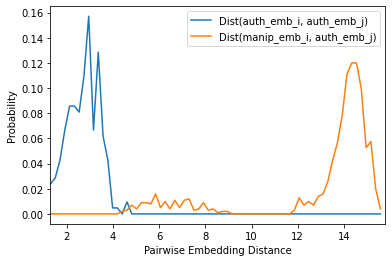

In [16]:
img_auth_v_auth, img_auth_v_manip = get_feature_distance_distribs((manipulated_images, masks), load_image)
# plt.figure(dpi=200)
plot_auth_vs_manip_distrib(img_auth_v_auth, img_auth_v_manip, title="Image")

0it [00:00, ?it/s]

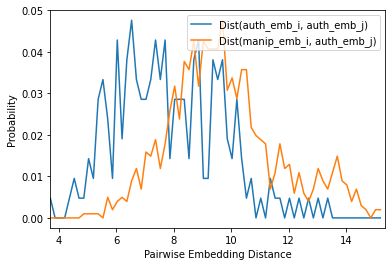

In [17]:
vid_auth_v_auth, vid_auth_v_manip = get_feature_distance_distribs((manipulated_videos, masks), load_first_frame_of_video)
# plt.figure(dpi=200)
plot_auth_vs_manip_distrib(vid_auth_v_auth, vid_auth_v_manip, title="Video")

[]

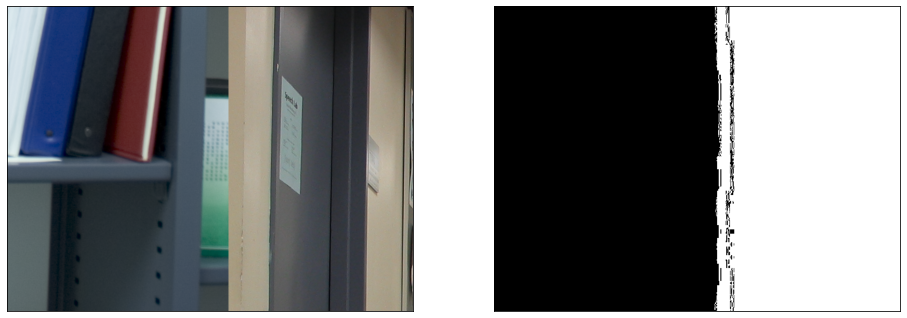

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

axes[0].imshow(plt.imread(manipulated_images[0]))
axes[0].set_xticks([])
axes[0].set_yticks([])

axes[1].imshow(1 - torch.tensor(plt.imread(masks[0])[:,:,1] > 0).int(), cmap="gray")
axes[1].set_xticks([])
axes[1].set_yticks([])

In [19]:
raise InterruptedError

InterruptedError: 

In [ ]:
image_feature_distances_dict = {
    "authentic_images": get_feature_distance_distrib(FSG, authentic_images, load_image),
    "manipulated_images": get_feature_distance_distrib(FSG, manipulated_images, load_image),
}

In [ ]:
video_feature_distances_dict = {
    "authentic_videos_1st_frame": get_feature_distance_distrib(FSG, authentic_videos, load_first_frame_of_video),
    # "authentic_videos_2nd_frame": get_feature_distance_distrib(FSG, authentic_videos, load_second_frame_of_video),
    "manipulated_videos_1st_frame": get_feature_distance_distrib(FSG, manipulated_videos, load_first_frame_of_video),
    # "manipulated_videos_2nd_frame": get_feature_distance_distrib(FSG, manipulated_videos, load_second_frame_of_video),
}

In [ ]:
# fig, axes = plt.subplots(1, 2, figsize=(10, 5))
# for i, (key, feature_distances) in enumerate(image_feature_distances_dict.items()):
#     plot_distrib_histogram(feature_distances, axes[i%2], title=key)
# plt.subplots_adjust(hspace=0.3)

In [ ]:
# fig, axes = plt.subplots(2, 2, figsize=(10, 10))
# for i, (key, feature_distances) in enumerate(video_feature_distances_dict.items()):
#     plot_distrib_histogram(feature_distances, axes[i//2, i%2], title=key)
# plt.subplots_adjust(hspace=0.3)

In [ ]:
plot_auth_vs_manip_distrib(image_feature_distances_dict["authentic_images"], image_feature_distances_dict["manipulated_images"], title="Image")

In [ ]:
plot_auth_vs_manip_distrib(video_feature_distances_dict["authentic_videos_1st_frame"], video_feature_distances_dict["manipulated_videos_1st_frame"], title="Video 1st Frame")

In [ ]:
# plot_auth_vs_manip_distrib(video_feature_distances_dict["authentic_videos_2nd_frame"], video_feature_distances_dict["manipulated_videos_2nd_frame"], title="Video 2nd Frame")

In [ ]:
def kl_div(p, q):
    epsilon = 1e-8
    hist1, _ = torch.histogram(p, bins=100)
    hist2, _ = torch.histogram(q, bins=100)
    pdf1 = hist1 / hist1.sum() + epsilon
    pdf2 = hist2 / hist2.sum() + epsilon
    return torch.sum(pdf1 * torch.log2(pdf1 / pdf2))

In [ ]:
(
    kl_div(image_feature_distances_dict["authentic_images"], image_feature_distances_dict["manipulated_images"]),
    kl_div(video_feature_distances_dict["authentic_videos_1st_frame"], video_feature_distances_dict["manipulated_videos_1st_frame"]),
)